In [1]:
import numpy as np
import tensorflow.keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
pkl_dir = "/scratch/hh2263/drum_data/pkl_data/"
os.listdir(pkl_dir)

['scattering_J-06_Q-01_order2.pkl',
 'scattering_J-10_Q-01_order1.pkl',
 'scattering_J-12_Q-01_order1.pkl',
 'scattering_J-14_Q-01_order1.pkl',
 'scattering_J-06_Q-01_order1.pkl',
 'scattering_J-08_Q-01_order1.pkl',
 'scattering_J-10_Q-01_order2.pkl',
 'scattering_J-08_Q-01_order2.pkl',
 'scattering_J-12_Q-01_order2.pkl',
 'scattering_J-14_Q-01_order2.pkl']

In [4]:
# open J-8,Q=1,O=2 pkl file
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/pkl_data/scattering_J-08_Q-01_order2.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/val/J_8_Q_1_order_2.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

In [5]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]
print(Sy_train.shape,Sy_val.shape,y_train.shape,y_val.shape,input_x,input_y)

(82224, 128, 43) (7776, 128, 43) (82224, 5) (7776, 5) 128 43


In [6]:
!nvidia-smi

Fri Mar 13 17:13:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:0E:00.0 Off |                    0 |
| N/A   30C    P8    28W / 149W |     11MiB / 11441MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)

In [7]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [9]:
model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 8)            1384      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 128, 8)            0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 8)             0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 8)             264       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 8)             32        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 8)             0

In [11]:
Sy_train.shape

(82224, 128, 43)

In [14]:
#feed the entire thing, use batch size of 4096
model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
hist = model.fit(Sy_train,
              y_train_normalized,
              epochs=8,
              verbose=2,
              batch_size=4096,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)



Train on 82224 samples, validate on 7776 samples
Epoch 1/8
82224/82224 - 12s - loss: 0.7081 - mean_squared_error: 0.7081 - val_loss: 0.1077 - val_mean_squared_error: 0.1077
Epoch 2/8
82224/82224 - 4s - loss: 0.1971 - mean_squared_error: 0.1971 - val_loss: 0.0677 - val_mean_squared_error: 0.0677
Epoch 3/8
82224/82224 - 4s - loss: 0.1117 - mean_squared_error: 0.1117 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 4/8
82224/82224 - 4s - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 5/8
82224/82224 - 4s - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 6/8
82224/82224 - 4s - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 7/8
82224/82224 - 4s - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 8/8
82224/82224 - 4s - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0664

In [15]:
#feed the entire thing, use batch size of 64
model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
hist = model.fit(Sy_train,
              y_train_normalized,
              epochs=8,
              verbose=2,
              batch_size=64,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)



Train on 82224 samples, validate on 7776 samples
Epoch 1/8
82224/82224 - 27s - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 901.6907 - val_mean_squared_error: 901.6904
Epoch 2/8
82224/82224 - 26s - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 3733.2078 - val_mean_squared_error: 3733.2080
Epoch 3/8
82224/82224 - 25s - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 12082.9765 - val_mean_squared_error: 12082.9785
Epoch 4/8
82224/82224 - 25s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 30886.8858 - val_mean_squared_error: 30886.8945
Epoch 5/8
82224/82224 - 25s - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 34040.8927 - val_mean_squared_error: 34040.8984
Epoch 6/8
82224/82224 - 26s - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 16500.4232 - val_mean_squared_error: 16500.4219
Epoch 7/8
82224/82224 - 26s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 16218.1727 - val_mean_squared_error: 16218.1738
Epoch 8/8
82224/82224 - 26s - los

In [18]:
idx = np.arange(0,10,1)
print(idx)

[0 1 2 3 4 5 6 7 8 9]


In [19]:
#divide the training up to 1/8, use batch size of 64
n = Sy_train.shape[0]
m = n // 8
idx = np.arange(0,n,1)
model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
for epoch in range(8):
    np.random.shuffle(idx)
    Sy_temp = Sy_train[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=1,
                batch_size=64,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=True)


Train on 10278 samples, validate on 7776 samples
10278/10278 [==============================] - 5s 515us/sample - loss: 0.1939 - mean_squared_error: 0.1939 - val_loss: 0.0433 - val_mean_squared_error: 0.0433
Train on 10278 samples, validate on 7776 samples
10278/10278 [==============================] - 4s 390us/sample - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.2056 - val_mean_squared_error: 0.2056
Train on 10278 samples, validate on 7776 samples
10278/10278 [==============================] - 4s 389us/sample - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 4.5236 - val_mean_squared_error: 4.5236
Train on 10278 samples, validate on 7776 samples
10278/10278 [==============================] - 4s 392us/sample - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 30.0759 - val_mean_squared_error: 30.0759
Train on 10278 samples, validate on 7776 samples
10278/10278 [==============================] - 4s 388us/sample - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss

In [20]:
#divide the training up to 1/16, use batch size of 64
n = Sy_train.shape[0]
m = n // 16
idx = np.arange(0,n,1)
model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
for epoch in range(8):
    np.random.shuffle(idx)
    Sy_temp = Sy_train[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=1,
                batch_size=64,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=True)



Train on 5139 samples, validate on 7776 samples
5139/5139 [==============================] - 4s 709us/sample - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Train on 5139 samples, validate on 7776 samples
5139/5139 [==============================] - 2s 461us/sample - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Train on 5139 samples, validate on 7776 samples
5139/5139 [==============================] - 2s 460us/sample - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Train on 5139 samples, validate on 7776 samples
5139/5139 [==============================] - 2s 467us/sample - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.1593 - val_mean_squared_error: 0.1593
Train on 5139 samples, validate on 7776 samples
5139/5139 [==============================] - 2s 462us/sample - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.2941 - val_me

In [23]:
#feed the entire thing, start with big batch size 8192 for three epoch, then decrease batch size

model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
bs = 8192
for epoch in range(4):
    model.fit(Sy_train,
              y_train_normalized,
              epochs=2,
              verbose=1,
              batch_size=bs,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)
    
    bs=bs//2
    print(bs)




Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 5s 63us/sample - loss: 0.9586 - mean_squared_error: 0.9586 - val_loss: 0.1305 - val_mean_squared_error: 0.1305
Epoch 2/2
82224/82224 [==============================] - 4s 49us/sample - loss: 0.3045 - mean_squared_error: 0.3045 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
4096
Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 4s 52us/sample - loss: 0.1584 - mean_squared_error: 0.1584 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 2/2
82224/82224 [==============================] - 4s 52us/sample - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
2048
Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 5s 60us/sample - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epo

In [24]:
#feed the entire thing, start with big batch size 4096 for three epoch, then decrease batch size

model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
bs = 4096
for epoch in range(4):
    model.fit(Sy_train,
              y_train_normalized,
              epochs=2,
              verbose=1,
              batch_size=bs,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)
    
    bs=bs//2
    print(bs)


Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 5s 64us/sample - loss: 0.6895 - mean_squared_error: 0.6895 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 2/2
82224/82224 [==============================] - 4s 50us/sample - loss: 0.1814 - mean_squared_error: 0.1814 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
2048
Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 4s 53us/sample - loss: 0.0870 - mean_squared_error: 0.0870 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 2/2
82224/82224 [==============================] - 5s 55us/sample - loss: 0.0524 - mean_squared_error: 0.0524 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
1024
Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 4s 46us/sample - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epo

In [25]:
#feed the entire thing, start with big batch size 4096 for three epoch, then decrease batch size

model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
bs = 4096
for epoch in range(2):
    model.fit(Sy_train,
              y_train_normalized,
              epochs=4,
              verbose=1,
              batch_size=bs,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)
    
    bs=bs//2
    print(bs)



Train on 82224 samples, validate on 7776 samples
Epoch 1/4
82224/82224 [==============================] - 5s 63us/sample - loss: 0.6700 - mean_squared_error: 0.6700 - val_loss: 0.0915 - val_mean_squared_error: 0.0915
Epoch 2/4
82224/82224 [==============================] - 4s 52us/sample - loss: 0.1786 - mean_squared_error: 0.1786 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 3/4
82224/82224 [==============================] - 4s 52us/sample - loss: 0.1019 - mean_squared_error: 0.1019 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 4/4
82224/82224 [==============================] - 4s 52us/sample - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
2048
Train on 82224 samples, validate on 7776 samples
Epoch 1/4
82224/82224 [==============================] - 5s 56us/sample - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 2/4
82224/82224 [==============================] - 

In [26]:
#feed the entire thing, start with big batch size 512 for two epoch, then increase batch size

model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
bs = 512
for epoch in range(4):
    model.fit(Sy_train,
              y_train_normalized,
              epochs=2,
              verbose=1,
              batch_size=bs,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)
    
    bs=bs*2
    print(bs)



Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 6s 78us/sample - loss: 0.1491 - mean_squared_error: 0.1491 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 2/2
82224/82224 [==============================] - 5s 66us/sample - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.9787 - val_mean_squared_error: 0.9787
1024
Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 4s 48us/sample - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 6.1805 - val_mean_squared_error: 6.1805
Epoch 2/2
82224/82224 [==============================] - 4s 49us/sample - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 18.8603 - val_mean_squared_error: 18.8603
2048
Train on 82224 samples, validate on 7776 samples
Epoch 1/2
82224/82224 [==============================] - 4s 53us/sample - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 30.2584 - val_mean_squared_error: 30.2584

## don't feed the entire thing! first epoch dont have to see all the data

In [44]:
#divide the training up to 1/8, use batch size of 64
n = Sy_train.shape[0]
steps_per_epoch = 5
bs = 64
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
loss=[]
model=create_model(J,Q,order,input_x,input_y,k_size=4,layer_size=4,nchan_out=8)
for epoch in range(40):
    np.random.shuffle(idx)
    Sy_temp = Sy_train[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=1,
                batch_size=bs,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=True)
    loss.append(hist.history['loss'])
    val_loss.append(hist.history['val_loss'])

Train on 320 samples, validate on 7776 samples
320/320 [==============================] - 2s 5ms/sample - loss: 1.3345 - mean_squared_error: 1.3345 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Train on 320 samples, validate on 7776 samples
320/320 [==============================] - 1s 2ms/sample - loss: 0.7304 - mean_squared_error: 0.7304 - val_loss: 0.1316 - val_mean_squared_error: 0.1316
Train on 320 samples, validate on 7776 samples
320/320 [==============================] - 1s 2ms/sample - loss: 0.5019 - mean_squared_error: 0.5019 - val_loss: 0.1159 - val_mean_squared_error: 0.1159
Train on 320 samples, validate on 7776 samples
320/320 [==============================] - 1s 2ms/sample - loss: 0.3894 - mean_squared_error: 0.3894 - val_loss: 0.1017 - val_mean_squared_error: 0.1017
Train on 320 samples, validate on 7776 samples
320/320 [==============================] - 1s 2ms/sample - loss: 0.3248 - mean_squared_error: 0.3248 - val_loss: 0.0895 - val_mean_squared_error: 0.0895


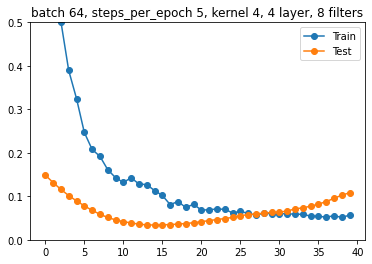

In [45]:
plt.plot(loss,'o-')
plt.plot(val_loss,'o-')
plt.ylim([0,0.5])
plt.title("batch 64, steps_per_epoch 5, kernel 4, 4 layer, 8 filters")
plt.legend(['Train', 'Test'])
plt.show()

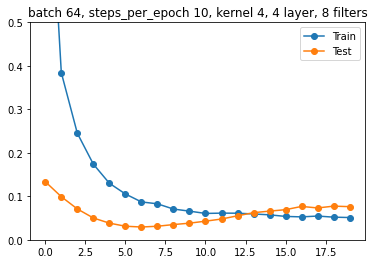

In [41]:
plt.plot(loss,'o-')
plt.plot(val_loss,'o-')
plt.ylim([0,0.5])
plt.title("batch 64, steps_per_epoch 10, kernel 4, 4 layer, 8 filters")
plt.legend(['Train', 'Test'])
plt.show()

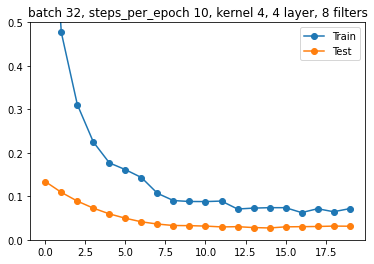

In [39]:
plt.plot(loss,'o-')
plt.plot(val_loss,'o-')
plt.ylim([0,0.5])
plt.title("batch 32, steps_per_epoch 10, kernel 4, 4 layer, 8 filters")
plt.legend(['Train', 'Test'])
plt.show()

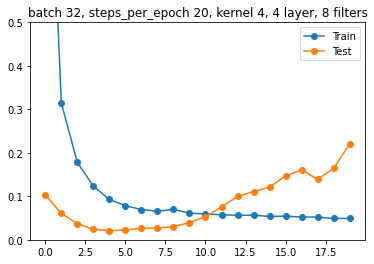

In [37]:
plt.plot(loss,'o-')
plt.plot(val_loss,'o-')
plt.ylim([0,0.5])
plt.title("batch 32, steps_per_epoch 20, kernel 4, 4 layer, 8 filters")
plt.legend(['Train', 'Test'])
plt.show()

In [32]:
import matplotlib.pyplot as plt

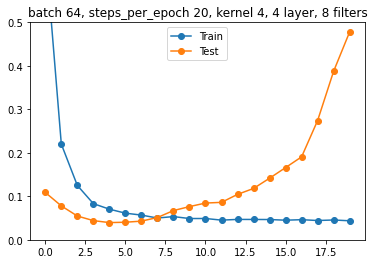

In [35]:
plt.plot(loss,'o-')
plt.plot(val_loss,'o-')
plt.ylim([0,0.5])
plt.title("batch 64, steps_per_epoch 20, kernel 4, 4 layer, 8 filters")
plt.legend(['Train', 'Test'])
plt.show()